# Encrypted MNIST Experiment

This notebook explores the effect of varying neural network parameters on accuracy, runtime, and memory when performing inference under Fully Homomorphic Encryption (FHE) with Concrete-ML.

We train a Multi-Layer Perceptron (MLP) on the MNIST dataset,
apply post-training quantization, and evaluate both in clear and under FHE(simulate and execute modes).

Our goal is to analyze the trade-offs between:
- **Accuracy**
- **Inference time (total and per sample)**
- **Memory usage**
- **Model parameters**

In [ ]:
# Imports

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import psutil
import glob,os
import tracemalloc
import random

from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, confusion_matrix
from concrete.ml.torch.compile import compile_torch_model



# Reproducibility
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Dataset

We use the MNIST dataset of handwritten digits (28x28 grayscale images).  
Preprocessing steps:
- Flatten images into vectors of size 784
- Normalize pixel values to [0,1]

We split the data into:
- **60,000 training samples**
- **10,000 test samples**

Later, we use slices of the test set (e.g., 2000 samples for simulate
and 256 samples for execute) to make experiments tractable.

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Flatten and convert to numpy
X_train = train_dataset.data.numpy().reshape(-1, 28 * 28).astype("float32") / 255.0
y_train = train_dataset.targets.numpy().astype("int64")
X_test = test_dataset.data.numpy().reshape(-1, 28 * 28).astype("float32") / 255.0
y_test = test_dataset.targets.numpy().astype("int64")

print("Dataset loaded:", X_train.shape[0], "train,", X_test.shape[0], "test")

Dataset loaded: 60000 train, 10000 test


## Model

We build a customizable Multi-Layer Perceptron (MLP).  
Parameters that we vary later:
- Number of hidden neurons (`hidden_dim`)
- Number of hidden layers (`n_layers`)
- Activation function (`relu`, `sigmoid`)
- Quantization bit-width (`n_bits`)

This flexibility allows us to study how each parameter influences both accuracy and efficiency under FHE.


In [ ]:
# Building a customizable MLP

activation_functions = {
    "relu": nn.ReLU(),
    "sigmoid": nn.Sigmoid(),
    "tanh": nn.Tanh(),
}

def build_mlp(input_dim=784, hidden_dim=128, n_hidden_layers=1, output_dim=10, activation="relu"):
    if activation not in activation_functions:
        raise ValueError("Unsupported activation: " + activation)

    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(activation_functions[activation])

    for _ in range(n_hidden_layers - 1):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(activation_functions[activation])

    layers.append(nn.Linear(hidden_dim, output_dim))

    return nn.Sequential(*layers)

In [ ]:
model = build_mlp(hidden_dim=64, n_hidden_layers=2, activation="sigmoid")

In [ ]:
# Training function

def train_model(model, X_train, y_train, epochs=5, batch_size=64, learning_rate=0.001):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X_train_tensor = torch.from_numpy(X_train) # convert nmpy array to pytorhc tensors objects :2D tensor of shape [60000, 784]
    y_train_tensor = torch.from_numpy(y_train) #1D tensor of shape [60000]
    num_batches = X_train_tensor.size(0) // batch_size # how many iterations happen inside each epoch

    for epoch in range(epochs):
      perm = torch.randperm(X_train_tensor.size(0))
      X_train_tensor = X_train_tensor[perm]
      y_train_tensor = y_train_tensor[perm]

      total_loss = 0.0
      for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        inputs = X_train_tensor[start:end]
        labels = y_train_tensor[start:end]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
      print("Epoch", epoch + 1, "Loss:", total_loss / num_batches)


    return model

In [ ]:
trained_model = train_model(model, X_train, y_train, epochs=5)

Epoch 1 Loss: 0.8091235601660282
Epoch 2 Loss: 0.25896350909402177
Epoch 3 Loss: 0.18830607406469013
Epoch 4 Loss: 0.14908853625300217
Epoch 5 Loss: 0.12169584597927084


## Quantization and Compilation

Concrete-ML requires quantized models to compile them into FHE circuits.  
We use post-training quantization (PTQ).

This step produces a quantized model that we can run in:
- **simulate mode**: emulates FHE computations in clear
- **execute mode**: performs real encrypted inference


In [ ]:
# Quantize and compile the model

from concrete.ml.torch.compile import compile_torch_model

def quantize_and_compile(model, X_calib, n_bits=6, rounding_threshold_bits=None):
    torch_input = torch.from_numpy(X_calib).float()

    if rounding_threshold_bits is None:
        rounding_threshold_bits = {"n_bits": n_bits, "method": "approximate"}

    quantized_module = compile_torch_model(
        model,
        torch_input,
        n_bits=n_bits,
        rounding_threshold_bits=rounding_threshold_bits
    )

    return quantized_module

In [ ]:
# A somehow large calibration set for stable quantization
X_calib = X_train[:2000]
quantized_model = quantize_and_compile(trained_model, X_calib, n_bits=6)

## Evaluation Metrics

For each experiment, we measure:
- Accuracy in clear vs simulate vs execute
- Total inference time
- Average time per sample
- Peak memory (Python and OS-level RSS)
- Agreement between predictions in different modes

This allows us to check correctness (simulate ≈ execute ≈ clear)
and compare efficiency.

In [ ]:
def evaluate_model(model, quantized_module, X, y, fhe_mode="disable", batch_size=128):
    n = X.shape[0]

    # Clear path with batching
    model.eval()
    preds_clear_list = []
    for i in range(0, n, batch_size):
        xb = torch.from_numpy(X[i:i+batch_size])
        with torch.no_grad():
            outb = model(xb)
        preds_clear_list.append(torch.argmax(outb, dim=1).numpy())
    preds_clear = np.concatenate(preds_clear_list, axis=0)

    # Quantized path with batching
    tracemalloc.start()
    proc = psutil.Process(os.getpid())
    rss_before = proc.memory_info().rss
    t0 = time.time()

    preds_q_list = []
    for i in range(0, n, batch_size):
        xb = X[i:i+batch_size]
        outb = quantized_module.forward(xb, fhe=fhe_mode)
        preds_q_list.append(outb.argmax(axis=1))
    preds_q = np.concatenate(preds_q_list, axis=0)

    t1 = time.time()
    current_bytes, peak_bytes = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    rss_after = proc.memory_info().rss

    # Metrics
    acc_clear = accuracy_score(y, preds_clear)
    acc_q = accuracy_score(y, preds_q)

    # Agreement
    diff_q_clear = int(np.sum(preds_q != preds_clear))

    return {
        "clear_accuracy": float(acc_clear),
        "quantized_accuracy": float(acc_q),
        "inference_time_s": float(t1 - t0),
        "time_per_sample_s": float((t1 - t0) / n),
        "py_peak_mb": float(peak_bytes / 1e6),
        "rss_before_mb": float(rss_before / 1e6),
        "rss_after_mb": float(rss_after / 1e6),
        "diff_q_clear": diff_q_clear,
        "preds_clear": preds_clear,
        "preds_quant": preds_q,
    }


In [ ]:
# Evaluation on a representative slice
X_eval = X_test[:2000].astype("float32")
y_eval = y_test[:2000]

# Simulate
res_sim = evaluate_model(trained_model, quantized_model, X_eval, y_eval, fhe_mode="simulate", batch_size=128)

print("Simulate results")
print("clear_accuracy", res_sim["clear_accuracy"])
print("quantized_accuracy", res_sim["quantized_accuracy"])
print("inference_time_s", res_sim["inference_time_s"])
print("time_per_sample_s", res_sim["time_per_sample_s"])
print("py_peak_mb", res_sim["py_peak_mb"])
print("rss_before_mb", res_sim["rss_before_mb"])
print("rss_after_mb", res_sim["rss_after_mb"])
print("diff_q_clear", res_sim["diff_q_clear"])

# Confusion matrix on clear baseline
cm = confusion_matrix(y_eval, res_sim["preds_clear"])
print("Confusion matrix shape", cm.shape)


Simulate results
clear_accuracy 0.9495
quantized_accuracy 0.949
inference_time_s 40.77262258529663
time_per_sample_s 0.020386311292648316
py_peak_mb 1.484876
rss_before_mb 1224.638464
rss_after_mb 1229.336576
diff_q_clear 29
Confusion matrix shape (10, 10)


## Grid Search Experiments

We systematically vary:
- Hidden dimension: 16, 32, 64, 128
- Number of layers: 1, 2, 3, 4
- Activation: ReLU, Sigmoid
- Quantization bits: 2, 3, 4, 5, 6

For each configuration:
1. Train the model in clear
2. Quantize and compile
3. Evaluate on 2000 test samples (simulate mode)

We log accuracy, runtime, memory usage, and agreement.
Results are stored in a DataFrame and exported to CSV.


In [ ]:
from itertools import product
import pandas as pd
import time

# Grille étendue
hidden_dims = [16, 32, 64, 128]
n_layers_list = [1, 2, 3, 4]
activations = ["relu", "sigmoid"]
n_bits_list = [2, 3, 4, 5, 6]

rows = []

# même tranche d’éval pour tout le monde
X_eval = X_test[:2000].astype("float32")
y_eval = y_test[:2000]

for hidden_dim, n_layers, activation, n_bits in product(hidden_dims, n_layers_list, activations, n_bits_list):
    print("Config", hidden_dim, "neurons", n_layers, "layers", activation, "activation", n_bits, "bits")

    # build et train
    mdl = build_mlp(hidden_dim=hidden_dim, n_hidden_layers=n_layers, activation=activation)

    t0_train = time.time()
    mdl = train_model(mdl, X_train, y_train, epochs=5)
    t1_train = time.time()
    train_time_s = t1_train - t0_train

    # compile avec calibration élargie
    X_calib = X_train[:5000]   # augmente si tu peux
    qmdl = quantize_and_compile(mdl, X_calib, n_bits=n_bits)

    # simulate
    met = evaluate_model(mdl, qmdl, X_eval, y_eval, fhe_mode="simulate", batch_size=128)

    rows.append({
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "activation": activation,
        "n_bits": n_bits,
        "acc_clear": met["clear_accuracy"],
        "acc_sim": met["quantized_accuracy"],
        "sim_time_s": met["inference_time_s"],
        "sim_time_per_sample_s": met["time_per_sample_s"],
        "train_time_s": train_time_s,
        "py_peak_mb": met["py_peak_mb"],
        "rss_before_mb": met["rss_before_mb"],
        "rss_after_mb": met["rss_after_mb"],
        "diff_sim_clear": met["diff_q_clear"],
    })

df_results = pd.DataFrame(rows)
print(df_results.head())
df_results.to_csv("mnist_quant_grid_large.csv", index=False)

Config 16 neurons 1 layers relu activation 2 bits
Epoch 1 Loss: 0.5629345852734566
Epoch 2 Loss: 0.2750660184464689
Epoch 3 Loss: 0.2387668894744988
Epoch 4 Loss: 0.21671109254150914
Epoch 5 Loss: 0.20275555897341085
Config 16 neurons 1 layers relu activation 3 bits
Epoch 1 Loss: 0.5431820677480041
Epoch 2 Loss: 0.2852817553084586
Epoch 3 Loss: 0.24892807700209074
Epoch 4 Loss: 0.22630018527393916
Epoch 5 Loss: 0.21019965749762737
Config 16 neurons 1 layers relu activation 4 bits
Epoch 1 Loss: 0.536272292131739
Epoch 2 Loss: 0.2862629190071415
Epoch 3 Loss: 0.2528156581649849
Epoch 4 Loss: 0.22985047647449225
Epoch 5 Loss: 0.21370499352492162
Config 16 neurons 1 layers relu activation 5 bits
Epoch 1 Loss: 0.5510319405997702
Epoch 2 Loss: 0.29492114708543204
Epoch 3 Loss: 0.26513646487365283
Epoch 4 Loss: 0.24169201205465685
Epoch 5 Loss: 0.2248516887816001
Config 16 neurons 1 layers relu activation 6 bits
Epoch 1 Loss: 0.5311758372149447
Epoch 2 Loss: 0.28523648729032997
Epoch 3 Loss: 

In [ ]:
# loading
csv_path = "mnist_quant_grid_large.csv"

print("Loading grid results from", csv_path)
df_results = pd.read_csv(csv_path)
print("Rows", len(df_results))
print(df_results.head())
print(df_results.columns.tolist())

Loading grid results from mnist_quant_grid_large.csv
Rows 160
   hidden_dim  n_layers activation  n_bits  acc_clear  acc_sim  sim_time_s  \
0          16         1       relu       2     0.9225   0.0895   30.033711   
1          16         1       relu       3     0.9225   0.5905   28.884572   
2          16         1       relu       4     0.9220   0.8565   28.716971   
3          16         1       relu       5     0.9195   0.9070   29.077140   
4          16         1       relu       6     0.9160   0.9175   29.303330   

   sim_time_per_sample_s  train_time_s  py_peak_mb  rss_before_mb  \
0               0.015017      2.772406    1.272737    1278.980096   
1               0.014442      2.850275    1.270548    1278.304256   
2               0.014358      2.926766    1.268013    1278.803968   
3               0.014539      2.783705    1.274065    1281.232896   
4               0.014652      2.781402    1.281262    1286.053888   

   rss_after_mb  diff_sim_clear  
0   1278.980096     

## Execute Mode (Real FHE)

Since execute is much more costly, we only test the top-performing
configurations (highest simulate accuracy).

We evaluate on 256 test samples to keep runtime manageable, and compare results between simulate and execute.

We check:
- Accuracy (clear vs simulate vs execute)
- Runtime differences
- Memory usage (RSS before/after)
- Agreement of predictions


In [ ]:
# Chosing best configurations basef on  acc_sim
topk = 3
best = df_results.sort_values("acc_sim", ascending=False).head(topk)

exec_rows = []

# executing on a small set
X_exec = X_test[:256].astype("float32")
y_exec = y_test[:256]

for _, row in best.iterrows():
    hidden_dim = int(row["hidden_dim"])
    n_layers = int(row["n_layers"])
    activation = row["activation"]
    n_bits = int(row["n_bits"])

    print("Execute for", hidden_dim, "neurons", n_layers, "layers", activation, "activation", n_bits, "bits")

    # rebuild et retrain
    mdl = build_mlp(hidden_dim=hidden_dim, n_hidden_layers=n_layers, activation=activation)
    mdl = train_model(mdl, X_train, y_train, epochs=5)

    # recompile
    X_calib = X_train[:5000]
    qmdl = quantize_and_compile(mdl, X_calib, n_bits=n_bits)

    # simulate
    met_sim_small = evaluate_model(mdl, qmdl, X_exec, y_exec, fhe_mode="simulate", batch_size=64)

    # execute (real))
    try:
        met_exec = evaluate_model(mdl, qmdl, X_exec, y_exec, fhe_mode="execute", batch_size=64)
    except Exception as e:
        print("execute failed", str(e))
        continue

    # checks
    preds_clear = met_sim_small["preds_clear"]
    preds_sim = met_sim_small["preds_quant"]
    preds_exec = met_exec["preds_quant"]

    diff_sim_clear  = int(np.sum(preds_sim  != preds_clear))
    diff_exec_clear = int(np.sum(preds_exec != preds_clear))
    diff_exec_sim   = int(np.sum(preds_exec != preds_sim))

    exec_rows.append({
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "activation": activation,
        "n_bits": n_bits,
        "acc_clear_256": met_sim_small["clear_accuracy"],
        "acc_sim_256": met_sim_small["quantized_accuracy"],
        "acc_exec_256": met_exec["quantized_accuracy"],
        "sim_time_s_256": met_sim_small["inference_time_s"],
        "exec_time_s_256": met_exec["inference_time_s"],
        "sim_t_per_sample_s_256": met_sim_small["time_per_sample_s"],
        "exec_t_per_sample_s_256": met_exec["time_per_sample_s"],
        "py_peak_mb_exec": met_exec["py_peak_mb"],
        "rss_before_mb_exec": met_exec["rss_before_mb"],
        "rss_after_mb_exec": met_exec["rss_after_mb"],
        "diff_sim_clear_256": diff_sim_clear,
        "diff_exec_clear_256": diff_exec_clear,
        "diff_exec_sim_256": diff_exec_sim,
    })

df_exec = pd.DataFrame(exec_rows)
print(df_exec)
df_exec.to_csv("mnist_exec_topk.csv", index=False)

Execute for 128 neurons 1 layers relu activation 6 bits
Epoch 1 Loss: 0.3459512770231595
Epoch 2 Loss: 0.16380120461395165
Epoch 3 Loss: 0.11235879108572146
Epoch 4 Loss: 0.08463416532081579
Epoch 5 Loss: 0.0658070724462472
Execute for 128 neurons 4 layers relu activation 6 bits
Epoch 1 Loss: 0.3429522239101162
Epoch 2 Loss: 0.12512967356340512
Epoch 3 Loss: 0.0897791395962771
Epoch 4 Loss: 0.0688219854325899
Epoch 5 Loss: 0.056179139850832116
Execute for 128 neurons 2 layers sigmoid activation 6 bits
Epoch 1 Loss: 0.6238929346569574
Epoch 2 Loss: 0.21019000971536753
Epoch 3 Loss: 0.14703357499390998
Epoch 4 Loss: 0.11135410495885631
Epoch 5 Loss: 0.08816281253652868
   hidden_dim  n_layers activation  n_bits  acc_clear_256  acc_sim_256  \
0         128         1       relu       6       0.988281     0.988281   
1         128         4       relu       6       0.976562     0.960938   
2         128         2    sigmoid       6       0.992188     0.988281   

   acc_exec_256  sim_time_s

## Results Visualization

We plot:
1. Accuracy vs number of quantization bits
2. Time per sample vs number of quantization bits

Curves are grouped by configuration (activation, hidden_dim, layers).  
This shows the trade-off: more bits generally increase accuracy but also increase computation time.


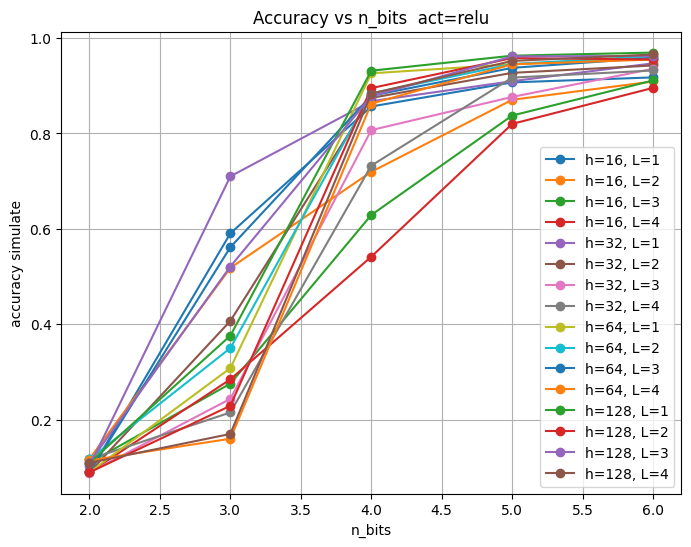

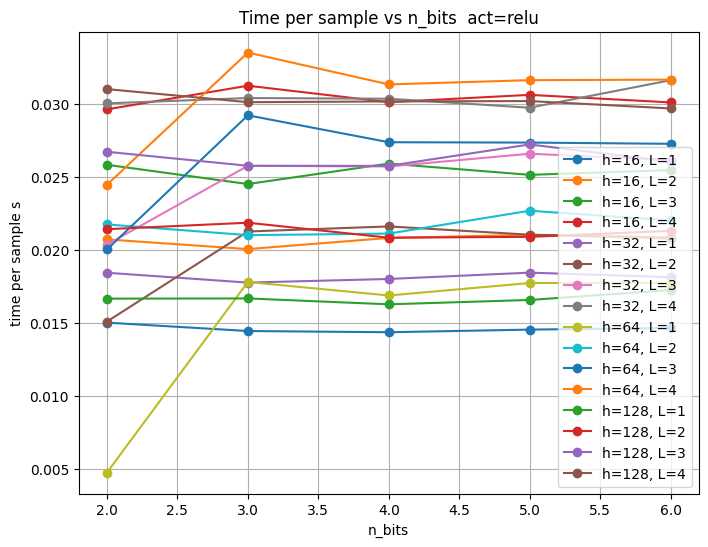

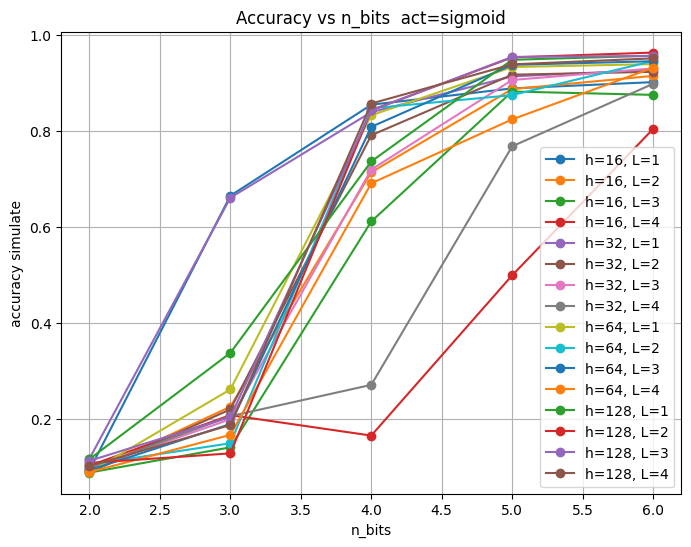

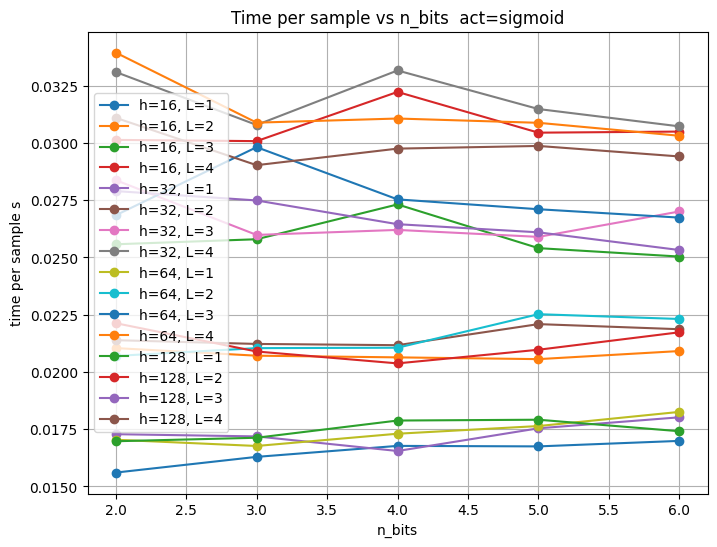

In [ ]:
import matplotlib.pyplot as plt

if "df_results" not in globals():
    raise RuntimeError("df_results is not defined. run the grid cell first.")

need = ["activation","n_bits","acc_sim","sim_time_per_sample_s","hidden_dim","n_layers"]
missing = [c for c in need if c not in df_results.columns]
if missing:
    raise RuntimeError("df_results is missing columns " + str(missing))

df_plot = df_results.copy()
df_plot["n_bits"] = df_plot["n_bits"].astype(int)
df_plot = df_plot.sort_values(["activation","hidden_dim","n_layers","n_bits"])

for act in sorted(df_plot["activation"].unique()):
    sub = df_plot[df_plot["activation"] == act]
    groups = sub.groupby(["hidden_dim","n_layers"])

    # accuracy vs n_bits
    plt.figure(figsize=(8,6))
    for (h,L), g in groups:
        plt.plot(g["n_bits"].values, g["acc_sim"].values, marker="o",
                 label="h="+str(h)+", L="+str(L))
    plt.title("Accuracy vs n_bits  act="+str(act))
    plt.xlabel("n_bits")
    plt.ylabel("accuracy simulate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # time per sample vs n_bits
    plt.figure(figsize=(8,6))
    for (h,L), g in groups:
        plt.plot(g["n_bits"].values, g["sim_time_per_sample_s"].values, marker="o",
                 label="h="+str(h)+", L="+str(L))
    plt.title("Time per sample vs n_bits  act="+str(act))
    plt.xlabel("n_bits")
    plt.ylabel("time per sample s")
    plt.legend()
    plt.grid(True)
    plt.show()


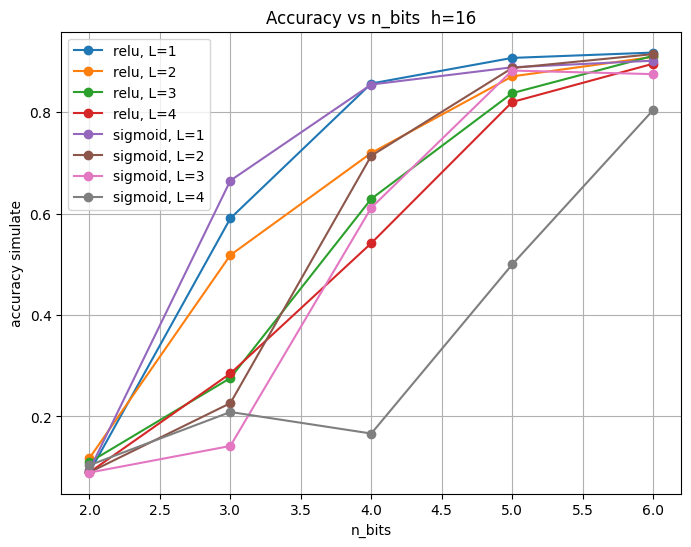

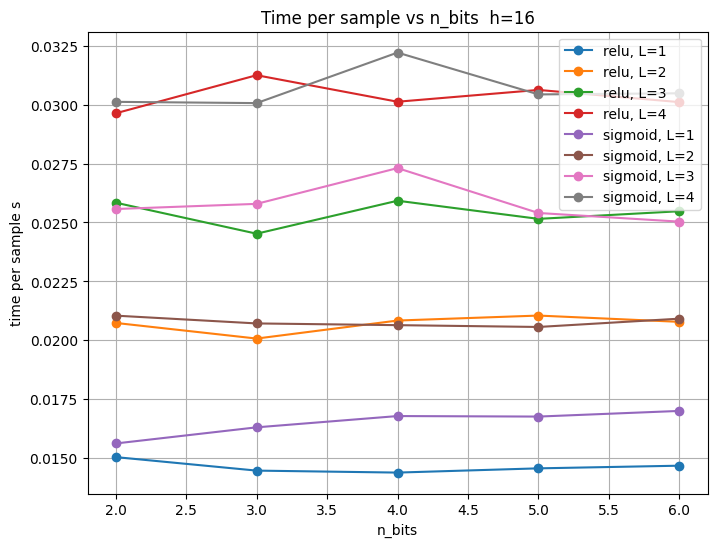

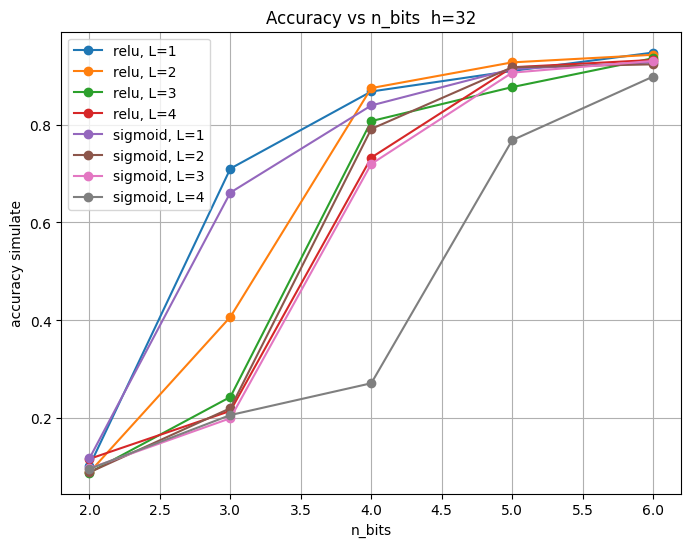

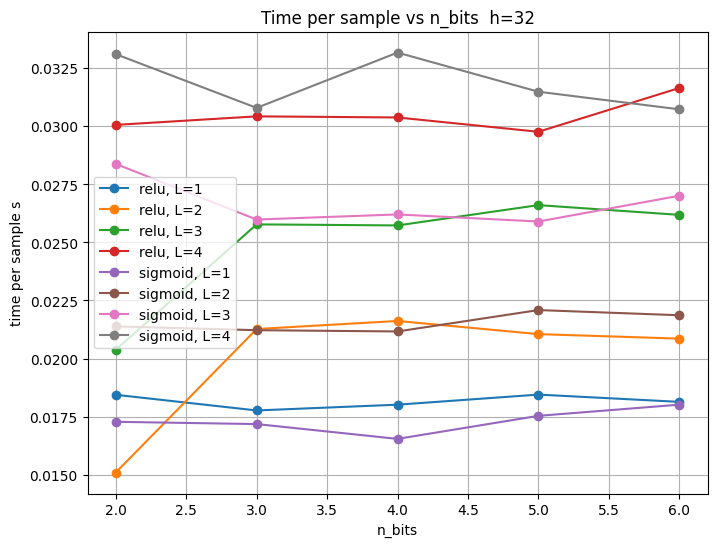

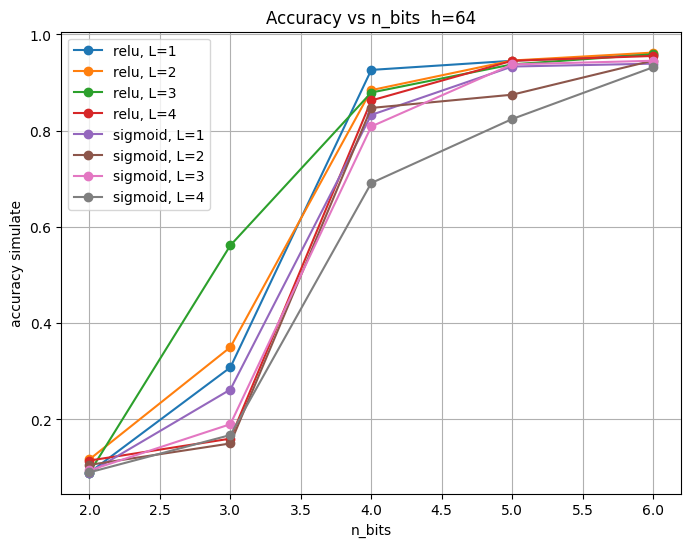

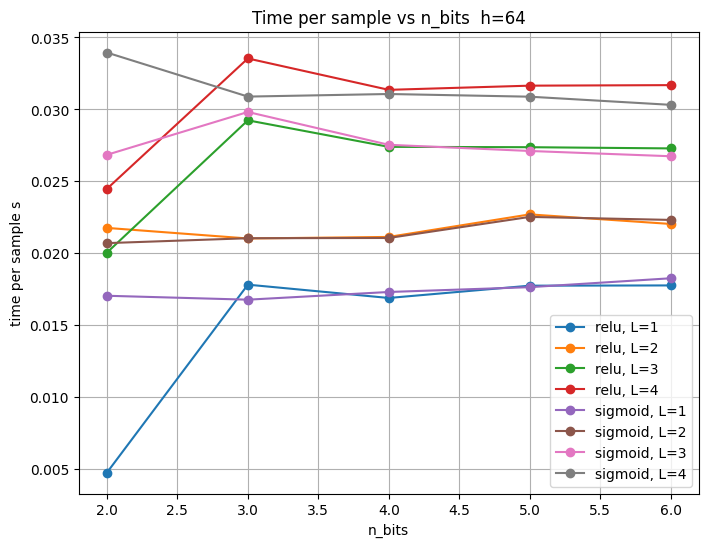

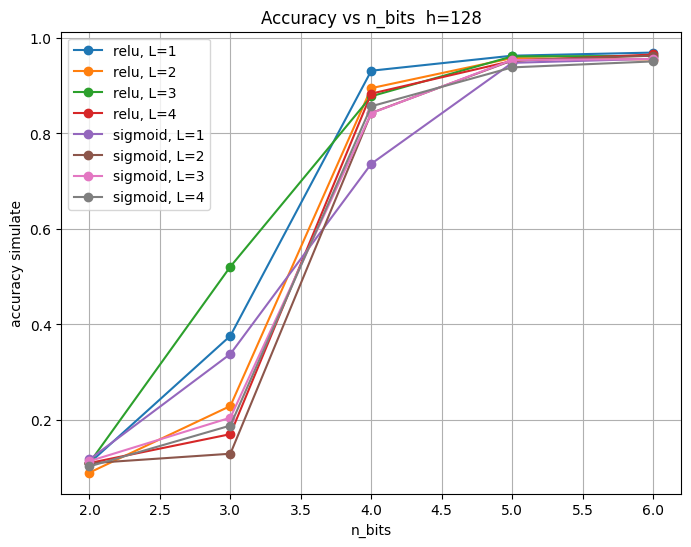

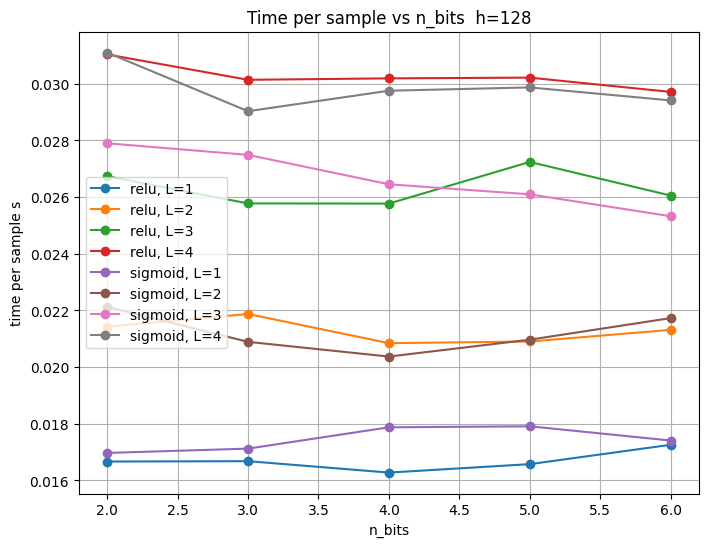

In [ ]:
import matplotlib.pyplot as plt

df_plot = df_results.copy()
df_plot["n_bits"] = df_plot["n_bits"].astype(int)
df_plot = df_plot.sort_values(["hidden_dim","activation","n_layers","n_bits"])

for h in sorted(df_plot["hidden_dim"].unique()):
    sub = df_plot[df_plot["hidden_dim"] == h]
    groups = sub.groupby(["activation","n_layers"])

    plt.figure(figsize=(8,6))
    for (act,L), g in groups:
        plt.plot(g["n_bits"].values, g["acc_sim"].values, marker="o",
                 label=act+", L="+str(L))
    plt.title("Accuracy vs n_bits  h="+str(h))
    plt.xlabel("n_bits")
    plt.ylabel("accuracy simulate")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,6))
    for (act,L), g in groups:
        plt.plot(g["n_bits"].values, g["sim_time_per_sample_s"].values, marker="o",
                 label=act+", L="+str(L))
    plt.title("Time per sample vs n_bits  h="+str(h))
    plt.xlabel("n_bits")
    plt.ylabel("time per sample s")
    plt.legend()
    plt.grid(True)
    plt.show()

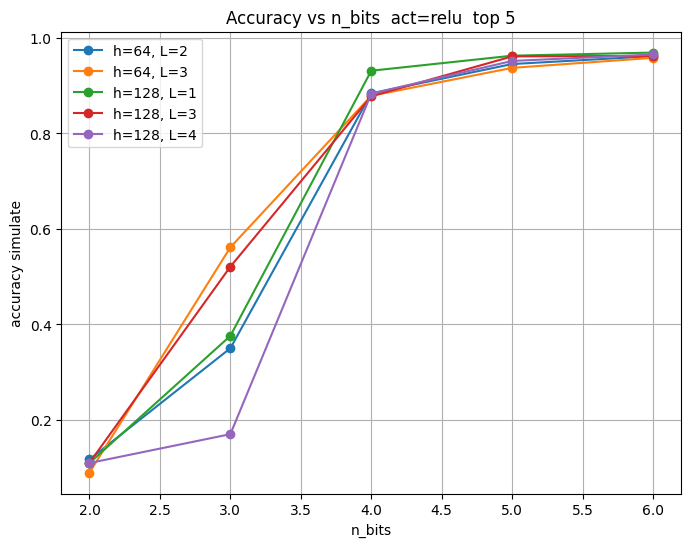

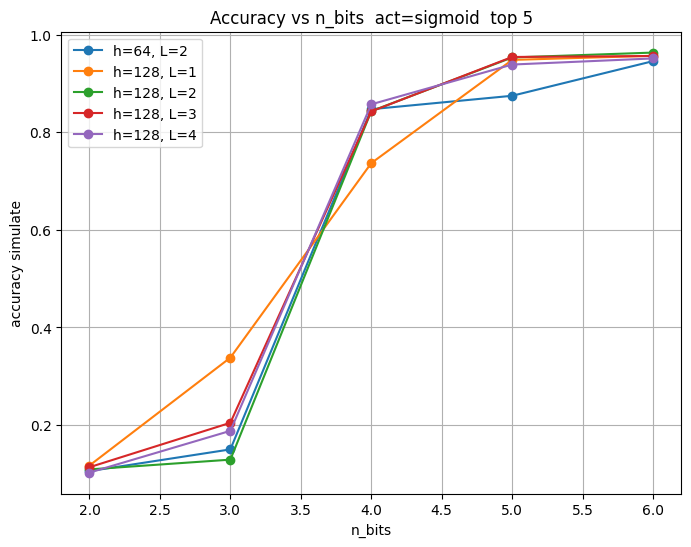

In [ ]:
import matplotlib.pyplot as plt

k = 5  # keep top k curves per activation

df_plot = df_results.copy()
df_plot["n_bits"] = df_plot["n_bits"].astype(int)

for act in sorted(df_plot["activation"].unique()):
    sub = df_plot[df_plot["activation"] == act]

    # score each pair hidden_dim x n_layers by max acc over n_bits
    best_pairs = (
        sub.groupby(["hidden_dim","n_layers"])["acc_sim"]
        .max()
        .sort_values(ascending=False)
        .head(k)
        .index.tolist()
    )
    pick = sub[sub[["hidden_dim","n_layers"]].apply(tuple, axis=1).isin(best_pairs)]
    groups = pick.groupby(["hidden_dim","n_layers"])

    plt.figure(figsize=(8,6))
    for (h,L), g in groups:
        g = g.sort_values("n_bits")
        plt.plot(g["n_bits"].values, g["acc_sim"].values, marker="o",
                 label="h="+str(h)+", L="+str(L))
    plt.title("Accuracy vs n_bits  act="+str(act)+"  top "+str(k))
    plt.xlabel("n_bits")
    plt.ylabel("accuracy simulate")
    plt.legend()
    plt.grid(True)
    plt.show()

# Conclusion

This notebook demonstrates the impact of changing model parameters
on encrypted inference with Concrete-ML.

Key takeaways:
- Accuracy improves with higher bit-widths and larger models, but at the cost of runtime and memory.
- Simulate and Execute modes show consistent results, validating correctness of FHE execution.
- Smaller models with moderate quantization (e.g., 6 bits, 2 layers, 64 neurons, ReLU) provide a good trade-off between
  accuracy and efficiency.

Further work could include:
- Measuring model sizes on disk
- Testing robustness to calibration and batch size choices
- Running multiple seeds to evaluate stability
